## Writeup

---

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"

[illustration000]: ./writeup_images/0000_distorted.jpg                                 
[illustration001]: ./writeup_images/0001_undistorted.jpg                               
[illustration002]: ./writeup_images/0002_undistorted_plus_distorted.jpg                
[illustration003]: ./writeup_images/0003_distorted.jpg                                 
[illustration004]: ./writeup_images/0004_undistorted.jpg                               
[illustration005]: ./writeup_images/0005_undistorted_plus_distorted.jpg                
[illustration006]: ./writeup_images/0006_transform_roi.jpg                             
[illustration007]: ./writeup_images/0007_birds_eye.jpg                                 
[illustration008]: ./writeup_images/0008_transform_roi.jpg                             
[illustration009]: ./writeup_images/0009_birds_eye.jpg                                 
[illustration010]: ./writeup_images/0010_transform_roi.jpg                             
[illustration011]: ./writeup_images/0011_birds_eye.jpg                                 
[illustration012]: ./writeup_images/0012_hls_color_space.jpg                           
[illustration013]: ./writeup_images/0013_luminosity.jpg                                
[illustration014]: ./writeup_images/0014_saturation.jpg                                
[illustration015]: ./writeup_images/0015_yellow.jpg                                    
[illustration016]: ./writeup_images/0016_yellow_balanced.jpg                           
[illustration017]: ./writeup_images/0017_sat_plus_yellow.jpg                           
[illustration018]: ./writeup_images/0018_luminosity_balanced.jpg                       
[illustration019]: ./writeup_images/0019_luminosity_highcontrast.jpg                   
[illustration020]: ./writeup_images/0020_yellsat_balanced.jpg                          
[illustration021]: ./writeup_images/0021_yellsat_highcontrast.jpg                      
[illustration022]: ./writeup_images/0022_yellsat_mix_lum.jpg                           
[illustration023]: ./writeup_images/0023_yellsat_mix_lum_highcontrast.jpg              
[illustration024]: ./writeup_images/0024_yellsat_mix_lum_highcontrast_clamped.jpg      
[illustration025]: ./writeup_images/0025_abs_sobelx_kernel_3.jpg                       
[illustration026]: ./writeup_images/0026_abs_sobely_kernel_3.jpg                       
[illustration027]: ./writeup_images/0027_gradient_angles.jpg                           
[illustration028]: ./writeup_images/0028_gradient_magnitude.jpg
[illustration029]: ./writeup_images/0029_angle_magnitude_combined.jpg
[illustration030]: ./writeup_images/0030_found_lane_pixels.jpg
[illustration031]: ./writeup_images/0031_taken_lane_pixels.jpg
[illustration032]: ./writeup_images/0032_demo_lanes_detected.jpg                       
[illustration033]: ./writeup_images/0033_pipeline_result.jpg



## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points

### Here I consider the rubric points individually and describe how I addressed each point in my implementation.  

---

### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is encapsulated in `./camera_calibrator.py` two classes definition. The CameraCalibrator class should be parametrized with a calibration images folder on construction. Then, the method `calibrate()` iterates through the given folder and calls `crunch_image()` for each ".jpg" image found. All calibration images are expected to be of the same pixel size. After a successful calibration, the calibration data (camera matrix, distortion coefficients) can be retrieved via `get_calibration_data()`. As there is only one type of usage of the calibration information, I do not store other calibration data, such as rotation and  translation vectors.

The calibration process is implemented according to [this tutorial](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html).
I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp_template` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function, and store the calibration data in `mtx` and `dist` class fields respectively.

To undistort an image using the calibration data, I have created a separate class `Undistorter`.
The class should be parametrized with a calibration data and an expected image shape on construction.
Then, any image can be undistorted, using the `undistort()` method.

Original image               |  Undistorted image
:---------------------------:|:-------------------------:
![distorted][illustration000]|![undistorted][illustration001]

Below is a mix of an original and undistorted images, where the original one is in red, and the undistorted
in the blue channel of an image:

![undistorted and distorted together][illustration002]


### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.

I have saved a grayscale distorted and undistorted road images, because that allows mixing them later using separate color channels to display the result. On a real road image, the difference between distorted and undistorted ones is not easily visible without channel mixing:

Grayscale img from camera    | Undistorted grayscale road image
:---------------------------:|:-------------------------:
![distorted][illustration003]|![undistorted][illustration004]

The resulting mix (original on red, undistorted on blue channel:

![undistorted and distorted together][illustration005]

As it can be easlily seen on the mixed road image, the camera distortions almost are not affecting the region where the lane lines are situated, so for this particular camera even a "raw", distorted image, would be good enough to find lanes and compute their curvature. However, as for a general approach, the undistortion is necessary by default.

#### 2. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

# TODO: DESCRIBE CODE!

I have performed tons of experiments tryng to find the best approach to reliably detect lane pixels, and then I tried to do the perspective transform **first**, before the contrast improvement and other thresholdings. This actually helped me a lot to deal with the "challenging" video.

To perform the perspective transforms (to the "bird-eye" view and back from it to the "road" view) I have  implemented a separate class `Bird` (that has its eye, kek) in `bird.py`.

While working on videos, it turned out that the "regular" and "challenge" videos have a bit different ROIs - probably, because of different camera position. So I have declared a `REGULAR_CAMERA_ROI` and a `CHALLENGE_CAMERA_ROI` arrays to use them separately.

```python
h_center = 640
h_offset = 50
top = 450
bottom = 690
left = 210
right = 1070
REGULAR_CAMERA_ROI = np.array([[left, bottom],
                               [h_center - h_offset, top],
                               [h_center + h_offset, top],
                               [right, bottom]]
                               , np.int32)
```
Please note the ROI points must be of a `np.int32` type to plot them on an image, but for the perspective  transform they must be of a `np.float32` type.

An instance of Bird should be parametrized with the two regions of interest: the first one represents 4 points on a 'bird-eye' view, and the second one represents a corresponding 4 points on a camera image.

For a regular video transformation, the ROIs are (starting from the bottom left point):

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 210, 690      | 260,  0       | 
| 590, 450      | 260,  720     |
| 690, 450      | 1020, 720     |
| 1070, 690     | 1020, 0       |


I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image:

Camera image ("road")        | Warped image ("from_above")
:---------------------------:|:-------------------------:
![road_view][illustration006]|![from_above][illustration007]
![road_view][illustration008]|![from_above][illustration009]
![road_view][illustration010]|![from_above][illustration011]

#### 3. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

# TODO: DESCRIBE CODE!

I have tried many variations of thresholding an RGB or HLS image, but without additional efforts it is almost impossible to tell the lane line apart from the background on the "challenging" frames with low contrast or pavement color change.

So I have developed a preprocessing pipeline, that uses:
* "Yellow" channel (50% of Red + 50% of Green)
* Saturation and luminosity channels
* Contrast improvement
* Vertical and close to vertical lines' pixels amplification and thresholding

Also, most of the processing is being done on "downsampled" images. I have adjusted the downsampling (e.g. shrinking) rate to a values (about 4..8 depending on the stage) that increases processing speed without significant accuracy lost.

Road view                    | Warped image ("from_above")
:---------------------------:|:-------------------------:
![road_view][illustration008]|![from_above][illustration009]


Image in HLS (displayed in BGR) | "Yellow" channel (50% red + 50% green) (downsampled)
:------------------------------:|:-------------------------:
![road_view][illustration012]   |![from_above][illustration015]

Saturation channel (ch 2 from HLS) | Luminosity channel (ch 1 from HLS)
:------------------------------:|:-------------------------:
![road_view][illustration014]   |![from_above][illustration013]

On some road images the contrast in saturation and yellow channels is poor, and the lane marking is not bright enough (as opposed to the pavement); but anyway while we have a pavement, the lane marking would always be brighter, and, probably it would be among the brightest objects in the image.
So I use this approach to improve contrast:

1. Find the most common pixel brightness (major tone) - presuming the lane marking is brighter
```python
# take histogram
hist = np.histogram(img)
# find the histogram peak == the most common brightness
major_tone = hist[1][np.argmax(hist[0])]
```
Note: the histogram is actually being taken from each N'th pixel, where N > 1, to increase the processing speed.

2. Subtract this value from all pixels - this way the most part of pavement becomes black
The result of major tone subtraction (I call it "balanced") is below:

Yellow              | Yellow balanced 
:------------------:|:------------------:
![][illustration015]|![][illustration016]

3. After balancing the image, the lane markings (highly probable) are the brightest parts of the image, so if we square all brightnesses, the distance between dim and bright part would significantly increase. Then the result of squaring is thresholded and normalized back to range 0..255.

```python
# Assume 'luminosity' is a 0..255 np.uint8 array, containing the luminosity channel
luminosity_highcontrast = np.minimum(np.power(luminosity.astype(np.uint16), 2), 2500))

```
After normalization back to 0..255 range, the brighter parts become much brighter, while the darker ones become black. I call this result a "highcontrast", here are all the "luminosity" channel processing stages for comparison:

Luminosity as-is    | Luminosity balanced| Luminosity highcontrast
:------------------:|:------------------:|:----------------------:
![][illustration013]|![][illustration018]|![][illustration019]

Meanwhile, the balanced yellow and the 'raw' saturation channel are summed. I have chosen this approach because the yellow lane marking might have a good brightness in both yellow channel and saturation channel, or in only one of them; but it is always much dimmer in luminosity channel (and of course is almost invisible in the blue channel).

Balanced yellow     | Saturation as-is   | 50% yellow + 50% saturation
:------------------:|:------------------:|:----------------------:
![][illustration016]|![][illustration014]|![][illustration017]

The Yellow+Saturation sum then is being made high-contrast, as described above:

 50% yellow + 50% saturation | yell + sat balanced | yell + sat highcontrast
:---------------------------:|:-------------------:|:----------------------:
![][illustration017]         |![][illustration020] |![][illustration021]  

After that we have the best possible contrast for a yellow lane marking in the `yell_sat_highcontrast`, and the best possible contrast for a white lane marking in `luminosity_highcontrast`, so I take the max value from both images to make an image where both lane markings are very bright, and the rest is dark:

 yell + sat highcontrast| Luminosity highcontrast | Maximum of both
:----------------------:|:-----------------------:|:-----------------:
![][illustration021]    |![][illustration019]     |![][illustration022]

This image is again processed to highcontrast to increase signa/noise ratio for furter processing:

![Highcontrast lane markings][illustration024]

Now it is time to use the geometrical information to separathe just a bright object from a lane marking. Assuming we have already warped the image, the lane markings would be always close to vertical, with a small angle difference from 90 degrees. Also, the lane markings (especially after several rounds of highcontrasting) would have a very sharp edges, e.g. the brightness gradient on them would have a high absolute magnitude.

To compute and threshold the angles, first take Sobel 'x' and 'y' component filters:

 Sobel filter, `x`  | Sobel filter, `y`
:------------------:|:------------------:
![][illustration025]|![][illustration026]

Then compute the angle and the gradient magnitude:

 Probable angle     | `x+y` gradient magnitude
:------------------:|:------------------:
![][illustration027]|![][illustration028]

Then we take only a pixels, that are both in some angle range *and* have a gradient magnitude above a threshold. That is the final result of the preprocessing pipeline:

![][illustration029]


#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

The pipeline uses 2 approaches for detecting lane pixels: a slower one, that is based on a sliding window and histogramming; and a faster one, which only takes all white pixels in the vicinity of a polynome curve. Of course, the second method is only applicable when the lane is already detected.

The sliding window method is implemented in the `find_lane_pixels()` function. It uses 9 steps per 720 pixels of an image height and the window total width is 200 pixels.

The input image (white), found lane curves (yellow and cyan), their respective pixels and the searching windows (green) are plotted below:

![found_lane_pixels][illustration030]

The second method just makes N windows along the known lane curves. The curves are being passed as a parameter to the `take_lane_pixels()` function. Then any non-zero pixel from the search (e.g. covered by rectangular windows) area is taken as new lane pixels. The lane curves, (yellow and cyan), their respective pixels and the searching area (grey) are plotted below:

![taken_lane_pixels][illustration031]

Based on the lane pixels, 2 curve polynomes are being fit in the `fit_polynomial()` function. In the images above the thin yellow and cyan line already represents the curves. Validation of the found lane curves might be done via plotting them (with a corresponding "unwarping" transform, made by `Bird.to_road()` method) to the road image:

![demo_lanes_detected][illustration032]


#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

# TODO: CODE DESCRIPTION

To track the lane lines, I have implemented a `LaneLine` class in `lane_line.py`.
When contructing, this class must be parametrized with a horizontal pixels-per-meter ratio `xm_per_pix` and a vertical one (`ym_per_pix`), as they depend on a particular ROI of the "bird", e.g. on the warp trasnformation parameters. Also there is an important `avg_depth` construction parameter, that sets the averaging coefficient in the simple averaging functions:

``` python3
# Presume we have some value, named `old_value` and equal to, say, 10
# and a new_value, equal to 50
avg_depth = 64
averaged = (old_value * (avg_depth - 1) + new_value) / avg_depth
# Now the 'averaged' is 10,625 - e.g. the glitch is filtered.
# After this, we need to save the existing data as an old one for next iteration.
old_value = averaged
```
I use this averaging approach in all cases whenever the averaging is required in this project. The formula above has a useful properties: 
1. If the values we work with are integers, all the math can be done in integer domain (which is fast)
2. If the averaging coefficient is a power of 2, the division and multiplication can be replaced with a combinantion of only biary shifts and addition/subtraction, which is much faster.
In the scope of this particular project I did not reimplement the averager as described above, however in a C++ production code for such a task I would definitely use this approach (and I have tested it a lot during my career, it is especially cool in embedded devices with slow FP math).

The class holds the the approximation polynome (`.avg_fit`), the curvature radius at the bottom (e.g. at the closest point to the car) (`.radius_m`), and the offset of a virtual lane center from the real screen center (and center of the car, by definition) (`.line_base_pos_mm`). For retrieving these values there are `get_fit()`, `get_radius()` and `get_horizontal_offset()` getters respectively.

There must be 2 instances of the class, for the left and right lane.

The `LaneLine` class computes all the necessary points when the `update()` method is called, this method takes an array of 3 polynomial coefficients. To prevent corrupting the data when a broken frame frame arrives, there are two mechanisms:
1. An absolute difference between the old and new coefficients is calculated. If this diff is above some predefined threshold, the new data is ignored, and the broken frame counter is incremented; the threshold is an experimentally adjusted value and might differ from video to video.
2. If the diff is below the allowed threshold, the lane polynome (`.avg_fit`) is being updated, using averaging with the existing data, to smooth any glitches.


#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in lines # through # in my code in `yet_another_file.py` in the function `map_lane()`.  Here is an example of my result on a test image:


![pipeline_result][illustration033]

---

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video.mp4)

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  

In [1]:
# Setting some project-global constants

# Matplotlib figure size to have large enough image plotting
FIGURE_SIZE = (12, 6)

TEST_IMG_OUTPUT_PATH = "test_images_output"

IMAGE_SHAPE = (1280, 720)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
%matplotlib inline
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [3]:
# Import everything we need from the project additional files
from camera_calibrator import CameraCalibrator, Undistorter
from lane_line import LaneLine
from bird import Bird

In [4]:
'''
This is an inplace helper class to save images from the various pipeline stages.
If a 'DEBUG_SAVING_MODE' is False, it always does nothing; in other cases
it might be blocked (no image saving) and unblocked (image is saved whenever a
`.write()` call occurs)
'''
DEBUG_SAVING_MODE = True
class ImagePrinter():
    def __init__(self, path):
        self.path = path
        self.reset()
        
    def write(self, img, name):
        if (not DEBUG_SAVING_MODE) or self.is_blocked:
            return
        filename = "{:04d}_{}.jpg".format(self.number, name)
        self.number += 1
        cv2.imwrite(os.path.join(self.path, filename), img)

    def reset(self):
        self.number = 0
        self.is_blocked = False
        
    def block(self):
        self.is_blocked = True
        
    def unblock(self):
        self.is_blocked = False
        

In [5]:
imgprinter = ImagePrinter(TEST_IMG_OUTPUT_PATH)

In [6]:
if not os.path.isdir(TEST_IMG_OUTPUT_PATH):
    os.mkdir(TEST_IMG_OUTPUT_PATH)
test_images = [ 'test_images/{}'.format(filename) for filename in os.listdir("test_images/") ]
test_images.sort()
print(test_images)

['test_images/challenge01.jpg', 'test_images/challenge3.jpg', 'test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


In [7]:
calibrator = CameraCalibrator(9, 6)
calibrator.calibrate()

Resetting Calibrator ...
Searching for calibration images at  camera_cal/*.jpg
20 files found for calibration.
Crunching camera_cal/calibration19.jpg ...
Crunching camera_cal/calibration20.jpg ...
Crunching camera_cal/calibration13.jpg ...
Crunching camera_cal/calibration15.jpg ...
Crunching camera_cal/calibration18.jpg ...
Crunching camera_cal/calibration2.jpg ...
Crunching camera_cal/calibration1.jpg ...
Crunching camera_cal/calibration17.jpg ...
Crunching camera_cal/calibration16.jpg ...
Crunching camera_cal/calibration5.jpg ...
Crunching camera_cal/calibration10.jpg ...
Crunching camera_cal/calibration8.jpg ...
Crunching camera_cal/calibration6.jpg ...
Crunching camera_cal/calibration4.jpg ...
Crunching camera_cal/calibration3.jpg ...
Crunching camera_cal/calibration12.jpg ...
Crunching camera_cal/calibration14.jpg ...
Crunching camera_cal/calibration7.jpg ...
Crunching camera_cal/calibration9.jpg ...
Crunching camera_cal/calibration11.jpg ...
Calibration successful


In [8]:
mtx, dist = calibrator.get_calibration_data()
undistorter = Undistorter(mtx, dist)

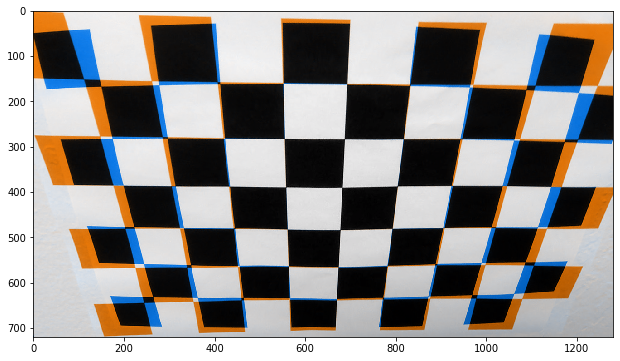

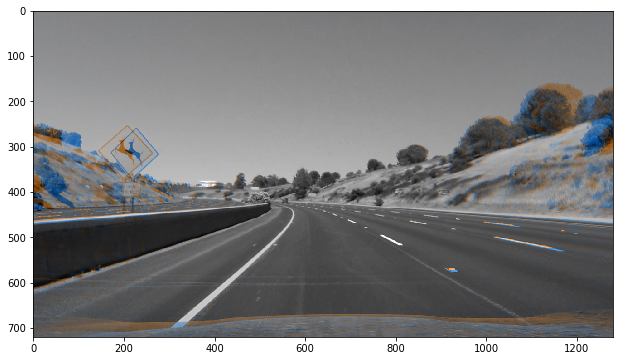

In [9]:
#
#    Calibrator and Undistorter validation
#

for filename in ['camera_cal/calibration2.jpg', test_images[5]]:
    img = cv2.imread(filename)
    distorted = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    undistorted = undistorter.undistort(distorted)

    out_shape = [undistorted.shape[0], undistorted.shape[1], 3]
    output = np.zeros(out_shape, dtype=np.uint8)
    output[:,:,0] = distorted
    output[:,:,1] = distorted//2 + undistorted//2
    output[:,:,2] = undistorted

    imgprinter.write(distorted, "distorted")
    imgprinter.write(undistorted, "undistorted")
    imgprinter.write(output, "undistorted_plus_distorted")

    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(output)

In [10]:
def plot_bgr(img):
    """ A helper for plotting a BGR image with matplotlib """
    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def plot_gray(gray):
    """ A helper for plotting a grayscale image with matplotlib """
    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(gray, cmap='gray')

def plot_roi_on(img, roi):
    """ A helper for plotting a 4-point ROI on a given image """
    if len(img.shape) == 2:
        output = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        output = img.copy()
    roi_color = (255, 0, 255)
    thickness = 4
    cv2.polylines(output, [roi], True, roi_color, thickness)
    return output
    
def normalize(img):
    """ Expects a 2D numpy array of any type, representing a grayscale image """
    """ Returns an np.uint8 array with range 0..255 """
    minimum = np.min(img)
    maximum = np.max(img)
    normalized = (((img + minimum) / (maximum - minimum) ) * 255).astype(np.uint8)
    return normalized

In [11]:
# Regular video best ROI is [210..1070] width, top 450 hoffs 40
# this corresponds (from above) to 700 pix x width == 3.75m, 720 pix y height = 27 m
h_center = 640
h_offset = 50    # 50 for regular, 70 for challenge
top = 450        # 450 for regular vid, 475 for challenge
bottom = 690
left = 210
right = 1070
REGULAR_CAMERA_ROI = np.array([[left, bottom],
                [h_center - h_offset, top],
                [h_center + h_offset, top],
                [right, bottom]]
               , np.int32)

h_center = 640
h_offset = 70    # 50 for regular, 70 for challenge
top = 475        # 450 for regular vid, 475 for challenge
bottom = 690
left = 210
right = 1070
CHALLENGE_CAMERA_ROI = np.array([[left, bottom],
                [h_center - h_offset, top],
                [h_center + h_offset, top],
                [right, bottom]]
               , np.int32)

CAMERA_ROI = REGULAR_CAMERA_ROI

birds_top = 0
birds_bottom = 720
birds_left = left +50
birds_right = right -50
BIRD_ROI =  np.float32([[birds_left, birds_bottom],
                       [birds_left, birds_top],
                       [birds_right, birds_top],
                       [birds_right, birds_bottom]])

bird = Bird(BIRD_ROI, CAMERA_ROI.astype(np.float32))

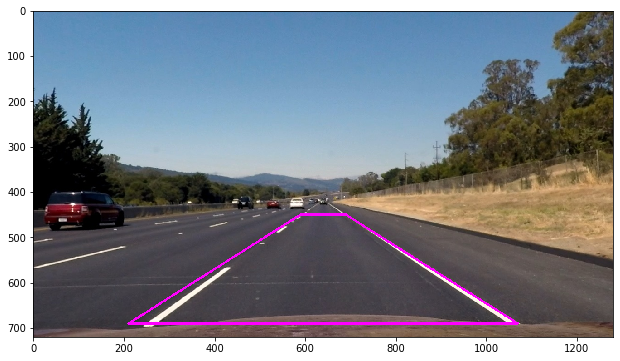

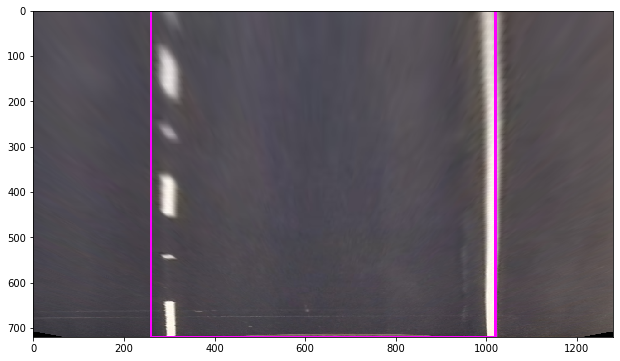

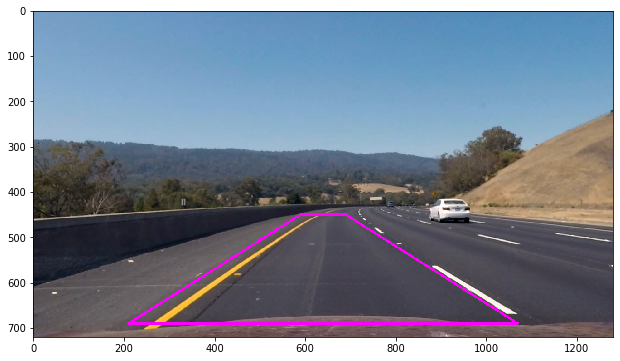

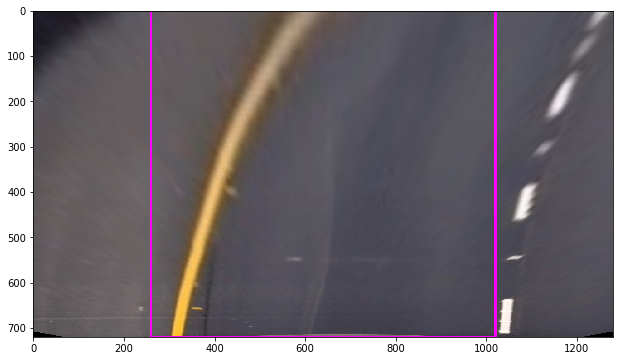

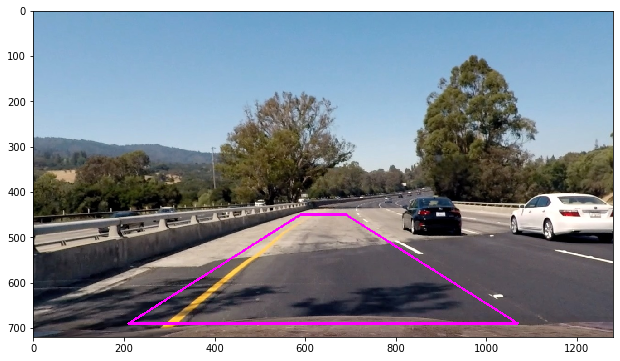

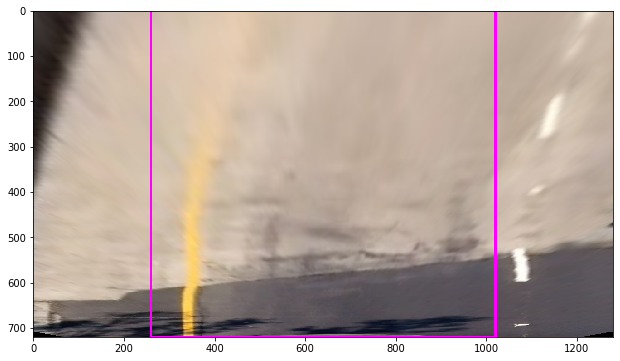

In [12]:
# Validate the warp transform
# https://docs.opencv.org/master/dc/da5/tutorial_py_drawing_functions.html
for test_img in [3,6,7]: # 3,6 and 7 are good examples

    img = cv2.resize(cv2.imread(test_images[test_img]), IMAGE_SHAPE)
    
    fpv = undistorter.undistort(img)
    
    fpv_roi = plot_roi_on(fpv, CAMERA_ROI)
    imgprinter.write(fpv_roi, "transform_roi")
        
    plot_bgr(fpv_roi)
    
    birds_eye = plot_roi_on(bird.from_above(fpv), BIRD_ROI.astype(np.int32))
    imgprinter.write(birds_eye, "birds_eye")

    plot_bgr(birds_eye)

In [13]:
def subtract_major_tone(img, downsample_rate=2, accuracy=10):
    """ 
    Finds the nmost popular pixel brightness (major tone) 
    and then subtracts it from the whole image. This way we shift
    brightness curve without adding significant artifacts (as opposed
    to a regular thresholding)
    """
    hist = np.histogram(img[::downsample_rate, ::downsample_rate], accuracy)
    major = hist[1][np.argmax(hist[0])]
    if (major <= 1.0):
        # In some cases, the most popular pixel in an image is black
        # and so there's nothing to subtract; but still we believe
        # the lane markings to be the brightest, and just
        # subtract the _second_ most popular pixel brightness.
        second_max = np.partition(hist[0], -2)[-2]
        second_max_idx = np.where(hist[0] == second_max)[0][0]
        major = hist[1][second_max_idx]

    return np.maximum(0, img.astype(np.int32) - major)

def adaptive_vertical_contrast(img, downsample_rate=2, save_output=False):
    """ Expects a cv2 mat (in BGR) as input """
    # The idea is to mix Lum and Sat channels to improve lane lines visibility
    height, width = img.shape[:2]
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    imgprinter.write(hls[::downsample_rate, ::downsample_rate, :], "hls_color_space")
    
    # Downsampling significantly increases processing speed
    # while introducing only a minor artifacts
    G = img[::downsample_rate, ::downsample_rate, 1]
    R = img[::downsample_rate, ::downsample_rate, 2]
    
    quarter_lum = hls[::downsample_rate, ::downsample_rate, 1]
    quarter_sat = hls[::downsample_rate, ::downsample_rate, 2]
    imgprinter.write(quarter_lum, "luminosity")
    imgprinter.write(quarter_sat, "saturation")

    # Yellow lane marking is the best recognizeabe as a sum of
    # yellow brightness and saturation channel
    yellow = R//2 + G//2
    imgprinter.write(yellow, "yellow")
    filtered_yellow = subtract_major_tone(yellow)
    imgprinter.write(filtered_yellow, "yellow_balanced")

    quarter_sat = quarter_sat//2 + filtered_yellow//2
    imgprinter.write(quarter_sat, "sat_plus_yellow")
    
    min_lum = subtract_major_tone(subtract_major_tone(quarter_lum))
    imgprinter.write(min_lum, "luminosity_balanced")
    lum_part = normalize(np.minimum(np.power(min_lum, 2), 2500)) #2500
    imgprinter.write(lum_part, "luminosity_highcontrast")

    min_sat = subtract_major_tone(subtract_major_tone(quarter_sat))
    imgprinter.write(min_sat, "yellsat_balanced")
    sat_part = normalize(np.minimum(np.power(min_sat, 2), 2000))
    imgprinter.write(sat_part, "yellsat_highcontrast")

    mix = np.uint16(np.maximum(sat_part, lum_part))
    imgprinter.write(mix, "yellsat_mix_lum")
    mix = normalize(np.power(mix, 2))
    imgprinter.write(mix, "yellsat_mix_lum_highcontrast")
    
    clamped_mix = np.maximum(0, np.minimum(mix, 255)).astype(np.uint8)
    imgprinter.write(clamped_mix, "yellsat_mix_lum_highcontrast_clamped")
    output = cv2.resize(clamped_mix, (width, height))
    return output

In [14]:
def amplify_vert_lane_pixels(gray_input, blur_radius=5, sobel_kernel=7,
                             angle_range=(-0.5, 0.5), magnitude_range=(20,255),
                             downsample_rate=4, save_output=False):
    """ Finds and amplifies pixels that are looking as lane line markings"""
    downsample = gray_input[::downsample_rate, ::downsample_rate]

    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(cv2.Sobel(downsample, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    imgprinter.write(normalize(abs_sobelx), "abs_sobelx_kernel_{}".format(sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(downsample, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    imgprinter.write(normalize(abs_sobely), "abs_sobely_kernel_{}".format(sobel_kernel))

    # Calculate the direction of the gradient and select only pixels
    # near edges of the matching slope (to the 'angle_range' in radians)
    angles = np.arctan2(abs_sobely, abs_sobelx)
    imgprinter.write(normalize(angles), "gradient_angles")
    (angle_min, angle_max) = angle_range

    # Calculate magnitude of the gradient
    mag_raw = normalize(np.sqrt(np.power(abs_sobelx, 2) + np.power(abs_sobely, 2)))
    imgprinter.write(normalize(mag_raw), "gradient_magnitude")
    min_magnitude, max_magnitude = magnitude_range;

    # Combining thresholds
    combined = np.zeros_like(downsample)
    combined[(((mag_raw > min_magnitude) & (mag_raw <= max_magnitude))\
              & ((angles >= angle_min) & (angles <= angle_max)))] = 255
    imgprinter.write(normalize(combined), "angle_magnitude_combined")
    output = cv2.resize(normalize(combined), (gray_input.shape[1], gray_input.shape[0]))

    return output

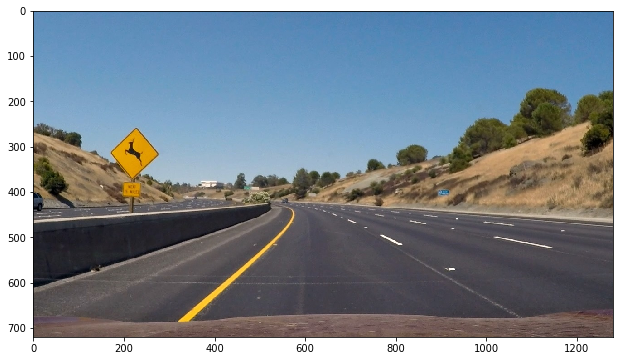

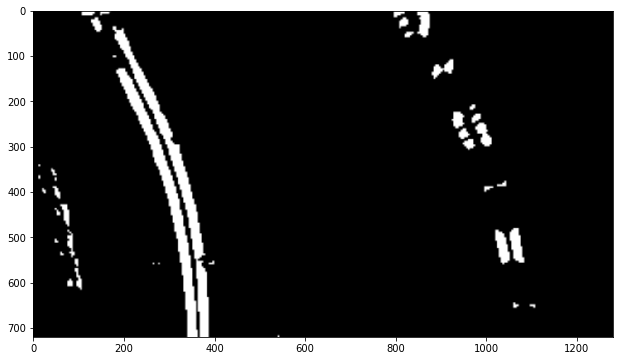

In [15]:
# Validate the HLS pipeline and plot pipeline frames
for test_img in test_images[5:6]:
    imgprinter.unblock()
    img = cv2.resize(cv2.imread(test_img), IMAGE_SHAPE)
    bird_eye = bird.from_above(undistorter.undistort(img))
    highcontrast = adaptive_vertical_contrast(bird_eye)
    probable_lane_pixels = amplify_vert_lane_pixels(highcontrast)
    plot_bgr(img)
    plot_gray(probable_lane_pixels)

In [16]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 27/720 # meters per pixel in y dimension for the regular video
xm_per_pix = 3.75/713 # meters per pixel in x dimension for the regular video

In [17]:
def get_lane_template_birdeye(shape, lane_width = 60):
    """ Returns an image with two white vertical stripes """
    width = shape[1]
    left_line_desired_position = width * 1 // 4
    right_line_desired_position = width * 3 // 4
    template = np.zeros(shape, dtype=np.uint8)
    template[:, left_line_desired_position-lane_width:left_line_desired_position+lane_width] = 255
    template[:, right_line_desired_position-lane_width:right_line_desired_position+lane_width] = 255
    return template

def find_lane_pixels(binary_warped, debug_img=None):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin 
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
                      (win_xleft_high, win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
                      (win_xright_high, win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix: 
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    if debug_img is not None:
        debug_img[:,:,:] = out_img[:,:,:]
    return leftx, lefty, rightx, righty

def take_lane_pixels(binary_warped, lcurve, rcurve, margin=50, debug_img=None):
    """
    Expects lcurve and rcurve as array of points.
    Vertical stride along the curve must be the same, and must be
    equal across both curves.
    These points are used as window origins: the point is a [bottom, h_center] of a window.
    Curves must be consistent with an image (e.g. of the same height and compatible width)
    """
    assert(len(lcurve) > 2 and len(rcurve) > 2)
    l_v_stride = lcurve[1][1] - lcurve[0][1]
    r_v_stride = rcurve[1][1] - rcurve[0][1]
    assert(l_v_stride == r_v_stride)
    v_stride = l_v_stride
    leftx = []; lefty = []; rightx = []; righty = []
    if debug_img is not None:
        debug_img[:,:] = binary_warped[:,:]
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    for point in lcurve:
        x, y = point
        w_left = x - margin; w_right = x + margin
        w_top = y; w_bottom = y + v_stride
        window = binary_warped[w_top:w_bottom, w_left:w_right]
        w_y_indices, w_x_indices = window.nonzero()
        if len(w_x_indices > 0):
            leftx.append(w_x_indices + w_left-1)
            lefty.append(w_y_indices + w_top-1)
        if debug_img is not None:
            debug_img[y:y+v_stride, w_left:w_right] = 100
    for point in rcurve:
        x, y = point
        w_left = x - margin; w_right = x + margin
        w_top = y; w_bottom = y + v_stride
        window = binary_warped[w_top:w_bottom, w_left:w_right]
        w_y_indices, w_x_indices = window.nonzero()
        if len(w_x_indices > 0):
            rightx.append(w_x_indices + w_left-1)
            righty.append(w_y_indices + w_top-1)
        if debug_img is not None:
            debug_img[y:y+v_stride, w_left:w_right] = 100
    leftx = np.concatenate(leftx) if len(leftx) > 0 else np.uint16([])
    lefty = np.concatenate(lefty) if len(lefty) > 0 else np.uint16([])
    rightx = np.concatenate(rightx) if len(rightx) > 0 else np.uint16([])
    righty = np.concatenate(righty) if len(righty) > 0 else np.uint16([])
    return leftx, lefty, rightx, righty

In [18]:
def fit_polynomial(binary_warped, leftx, lefty, rightx, righty, xm_per_pix, ym_per_pix):
    if (len(leftx) == 0 or len(lefty) == 0 or len(rightx) == 0 or len(righty) == 0):
        salted = get_lane_template_birdeye(binary_warped.shape)
        leftx, lefty, rightx, righty = find_lane_pixels(salted)
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return left_fit, right_fit

def get_plottable_curves(height, left_fit, right_fit, xm_per_pix, ym_per_pix, steps=20):
    ploty = np.linspace(0, height, steps)
    left_curve = np.int32(list(zip(
        LaneLine.evaluate_poly2(left_fit, ploty * ym_per_pix) / xm_per_pix, ploty)))
    right_curve = np.int32(list(zip(
        LaneLine.evaluate_poly2(right_fit, ploty * ym_per_pix) / xm_per_pix, ploty)))
    return left_curve, right_curve
    
def plot_lane_curves(lane_img, left_curve, right_curve, thickness=6):
    out_img = cv2.polylines(lane_img, [left_curve], False, [0,255,255], thickness)
    out_img = cv2.polylines(out_img, [right_curve], False, [255,255,0], thickness)
    return out_img

def plot_lane_poly_on(lane_img, left_curve, right_curve, color=[100,200,100]):
    # Right curve's points must go in the opposite order to maintain a
    # polygon's points traversing order.
    points = np.append(left_curve, right_curve[::-1], axis=0)
    cv2.fillPoly(lane_img, [points], color)

In [19]:
def plot_circles(img, lcurv, rcurv):
    avg_curv = (lcurv + rcurv) / 2
    r_color = [0, 0, 255]
    l_color = [255, 0, 255]
    thickness = 15
    height, width = img.shape[:2]
    h_center = width // 2
    left_avg_center = (int(h_center - avg_curv), height)
    right_avg_center = (int(h_center + avg_curv), height)
    cv2.circle(img, left_avg_center, int(avg_curv), l_color, thickness)
    cv2.circle(img, right_avg_center, int(avg_curv), r_color, thickness)
    
def plot_curvatures_on(img, lcurvature, rcurvature, color=(20, 20, 20), fontScale = 1.3, thickness = 3):
    height, width = img.shape[:2]
    font = cv2.FONT_HERSHEY_SIMPLEX 
    
    # As the curvature radius calculation is not precise, I round
    # results to 10 meters (e.g. to the second integer digit)
    message = "Lane radius: ~{:4.0f} m    (left {:4.0f} m, right {:4.0f} m)".format(
                                round((lcurvature + rcurvature) / 2, -1),
                                round(lcurvature, -1),
                                round(rcurvature, -1), )

    origin = (int(width * 0.05), int(height * 0.1)) 
    output = cv2.putText(img, message, origin, font, fontScale, (200,200,200), 15, cv2.LINE_AA)
    return cv2.putText(output, message, origin, font, fontScale, color, thickness, cv2.LINE_AA)

def plot_hcenter_offset_on(img, loffset, roffset, thickness = 1):
    offset = loffset + roffset
    height, width = img.shape[:2]
    green = (50, 150, 50)
    blue = (150, 50, 50)
    message = "Offset {:4.0f} mm" .format(round(abs(offset), -1))
    r_origin = (int(width * 0.52), int(height * 0.9)) 
    l_origin = (int(width * 0.20), int(height * 0.9)) 
    origin = r_origin if (offset > 0) else l_origin
    color = green if (offset > 0) else blue
    font = cv2.FONT_HERSHEY_SIMPLEX 
    fontScale = 1.2; thickness = 2
    output = cv2.putText(img, message, origin, font, fontScale, (200,200,200), 10, cv2.LINE_AA)
    return cv2.putText(output, message, origin, font, fontScale, color, thickness, cv2.LINE_AA)
    

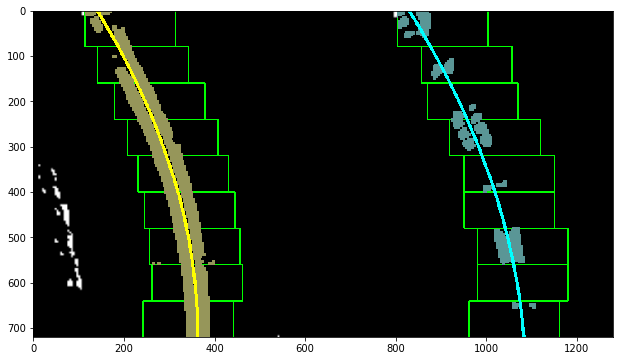

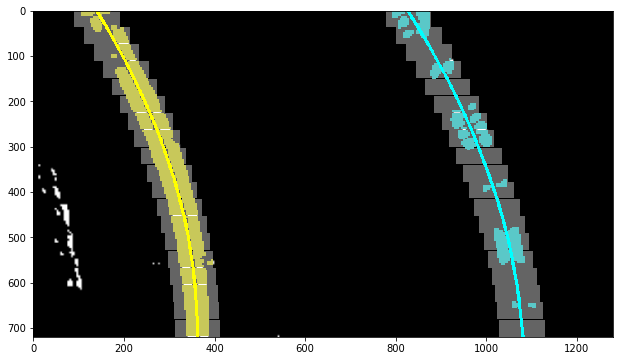

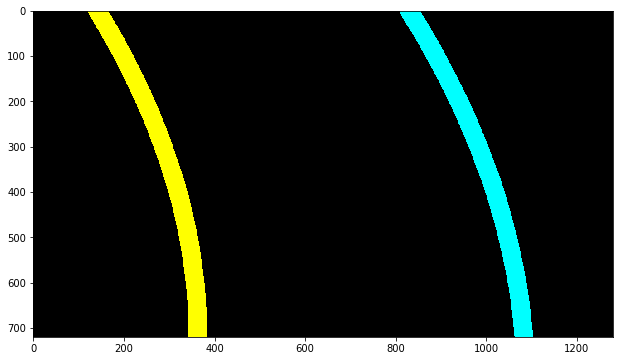

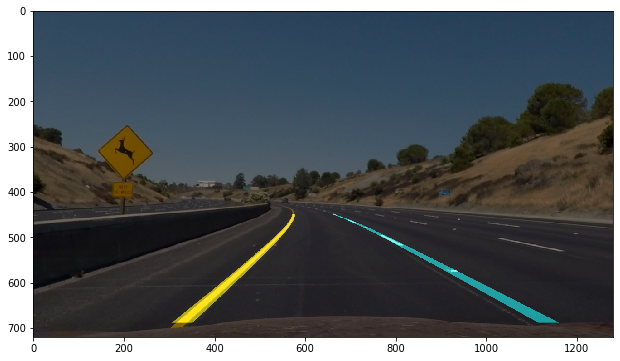

In [20]:
# Validate lane pixel finding via sliding window
for test_img in test_images[5:6]:
    imgprinter.block()
    img = cv2.resize(undistorter.undistort(cv2.imread(test_img)), IMAGE_SHAPE)
    hls = adaptive_vertical_contrast(bird.from_above(img))
    probable_lane_pixels = amplify_vert_lane_pixels(hls)

    # Debug image for find_lane_pixels will show the search windows
    debug_image_3ch = np.zeros_like(img)
    lx, ly, rx, ry = find_lane_pixels(probable_lane_pixels, debug_image_3ch)
    
    cv2.imwrite("bird_eye.png", probable_lane_pixels)
    lfit, rfit = fit_polynomial(probable_lane_pixels, lx, ly, rx, ry, xm_per_pix, ym_per_pix)
    lcurve, rcurve = get_plottable_curves(img.shape[0], lfit, rfit, xm_per_pix, ym_per_pix)
    
    # Debug image for take_lane_pixels will show the taking process areas
    debug_img_1ch = np.zeros_like(probable_lane_pixels)
    lx2,ly2,rx2,ry2 = take_lane_pixels(probable_lane_pixels, lcurve, rcurve, debug_img=debug_img_1ch)
    lfit2, rfit2 = fit_polynomial(probable_lane_pixels, lx2, ly2, rx2, ry2, xm_per_pix, ym_per_pix)
    lcurve2, rcurve2 = get_plottable_curves(img.shape[0], lfit2, rfit2, xm_per_pix, ym_per_pix)

    found = debug_image_3ch
    found[ly, lx] = [90, 150 , 150]
    found[ry, rx] = [150, 150, 90]
    found = plot_lane_curves(found, lcurve, rcurve)

    lcurv = LaneLine.curvature(lfit, 720 * ym_per_pix)
    rcurv = LaneLine.curvature(rfit, 720 * ym_per_pix)
      
    imgprinter.unblock()
    plot_bgr(found)
    imgprinter.write(found, "found_lane_pixels")
    
    taken = cv2.cvtColor(debug_img_1ch, cv2.COLOR_GRAY2BGR)
    taken = np.maximum(taken, cv2.cvtColor(probable_lane_pixels, cv2.COLOR_GRAY2BGR))
    taken[ly2, lx2] = [90, 200 , 200]
    taken[ry2, rx2] = [200, 200, 90]
    taken = plot_lane_curves(taken, lcurve2, rcurve2)
    plot_bgr(taken)
    imgprinter.write(taken, "taken_lane_pixels")

    
    lane_curves_from_above = plot_lane_curves(np.zeros_like(found), lcurve, rcurve, thickness=40)
    plot_bgr(lane_curves_from_above)
    
    lane_curves_on_road = bird.to_road(lane_curves_from_above)
    demo = np.uint8((img.astype(np.uint16) + lane_curves_on_road)//2)
    plot_bgr(demo)
    imgprinter.write(demo, "demo_lanes_detected")

In [23]:
# Note: an Undistorter instance is necessary
# with avg 10 lanes work. L8 + Buf32(_20) is ok too.
# Avg6 + Buf32(_20) works too.
# Avg4 + Buf8(_40) for regular video is ok
# Avg8 + Buf8(_20) for challenge is ok too.
rlane = LaneLine(xm_per_pix, ym_per_pix, avg_depth=8, max_valid_diff=0.75, max_broken_frames=12, name="Right")
llane = LaneLine(xm_per_pix, ym_per_pix, avg_depth=8, max_valid_diff=0.75, max_broken_frames=12, name="Left")

buffer_frame = None
buf_avg = 12

def process_frame(input_frame, plot_many=False):
    if input_frame.shape[:2] != [720, 1280]:
        frame = cv2.resize(input_frame, IMAGE_SHAPE)
    else:
        frame = input_frame
    imgprinter.block()
    global buffer_frame, buf_avg
    global rlane, llane
    
    is_all_ok = (llane.is_valid() and rlane.is_valid())
    downsample_rate = 2
    
    """ Expects an RGB frame as input """
    height, width, _ = frame.shape
    birds_eye = bird.from_above(undistorter.undistort(frame))
    highcontrast = adaptive_vertical_contrast(birds_eye, downsample_rate=downsample_rate)
    probable_lane_pixels = amplify_vert_lane_pixels(highcontrast, downsample_rate=downsample_rate)
    
    if buffer_frame is None:
        buffer_frame = np.uint32(probable_lane_pixels)
    else:
        buffer_frame = (buffer_frame * (buf_avg - 1) + probable_lane_pixels) / buf_avg

    filtered_stage2 = np.zeros_like(probable_lane_pixels)
    filtered_stage2[buffer_frame > 20] = 1
    filtered_stage2 = cv2.morphologyEx(filtered_stage2, cv2.MORPH_OPEN, np.ones((5,5)))

    if is_all_ok:
        # Faster
        downsample_rate = 10
        lx, ly, rx, ry = take_lane_pixels(filtered_stage2,
                                          llane.get_curve(),
                                          rlane.get_curve(),
                                          margin=80)
    else:
        # More robust
        downsample_rate = 2
        lx, ly, rx, ry = find_lane_pixels(filtered_stage2)
    
    # To fit a polynome curve, we need as few points as possible, as it 
    # speeds up computations; but not too few to keep the accuracy.
    fit_downsample = 1 + max(len(lx), len(ly)) // 1000
    lfit, rfit = fit_polynomial(filtered_stage2,
                                lx[::fit_downsample],
                                ly[::fit_downsample],
                                rx[::fit_downsample],
                                ry[::fit_downsample],
                                xm_per_pix, ym_per_pix)
    llane.update(lfit); 
    rlane.update(rfit);
    
    lcurve, rcurve = get_plottable_curves(height, llane.get_fit(), rlane.get_fit()
                                          , xm_per_pix, ym_per_pix, steps=15)
    llane.set_curve(lcurve)
    rlane.set_curve(rcurve)
    
    found_lanes = plot_lane_curves(cv2.cvtColor(normalize(filtered_stage2),
                                                   cv2.COLOR_GRAY2BGR)
                                      , lcurve, rcurve)
    
    road_poly_from_above = np.zeros_like(frame)
    poly_color = [100,200,100] if is_all_ok else [255,0,0]
    plot_lane_poly_on(road_poly_from_above, lcurve, rcurve, color=poly_color)
    lane_poly = bird.to_road(road_poly_from_above)
    detection_result = np.maximum(frame, lane_poly)
    plot_curvatures_on(detection_result, llane.get_radius(), rlane.get_radius())
    plot_hcenter_offset_on(detection_result, llane.get_horizontal_offset(), rlane.get_horizontal_offset())

    if not plot_many:
        return detection_result
            
    tile_00 = cv2.resize(detection_result, (width//2, height//2))
    tile_01 = cv2.cvtColor(cv2.resize(highcontrast, (width//2, height//2)), cv2.COLOR_GRAY2BGR)
    tile_10 = cv2.cvtColor(cv2.resize(probable_lane_pixels, (width//2, height//2)), cv2.COLOR_GRAY2BGR)
    tile_11 = cv2.resize(found_lanes, (width//2, height//2))

    output = np.zeros_like(frame)
    output [:height//2, :width//2] = tile_00
    output [:height//2, width//2:] = tile_01
    output [height//2:, :width//2] = tile_10
    output [height//2:, width//2:] = tile_11
    imgprinter.unblock()
    return output

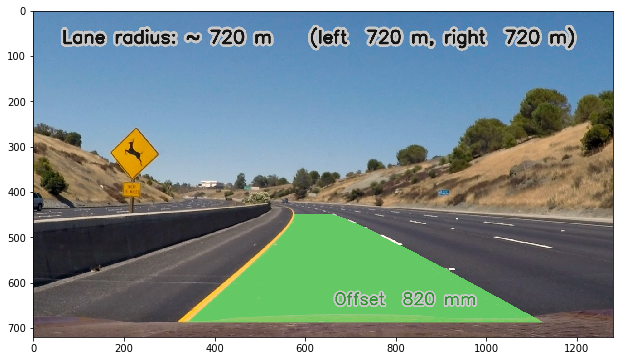

In [24]:
# Validate lane pixel finding via sliding window
for test_img in test_images[5:6]:
    for i in range(0, 3): # processing the same frame several times to trigger averaging
        img = cv2.resize(cv2.imread(test_img), IMAGE_SHAPE)
        process_frame(img)
    result = process_frame(img)
    plot_bgr(result)
    cv2.imwrite(test_img.replace('test_images','output_images'), result)
    imgprinter.unblock()
    imgprinter.write(result, "pipeline_result")
    buffer_frame = None
    llane.reset()
    rlane.reset()

In [ ]:
#input_video = 'harder_challenge_video.mp4'; test_video_output = 'test_video_output/harder_challenge_test_video.mp4'
#input_video = 'challenge_video.mp4'; test_video_output = 'test_video_output/challenge_test_video.mp4'
#input_video = 'project_video.mp4'; test_video_output = 'test_video_output/test_video.mp4'
input_video = 'solidWhiteRight.mp4'; test_video_output = 'test_video_output/solidWhiteRight.mp4'
imgprinter.block()
# 37-43 subclip of the main one is the worst, challenge problem on 3..6
clip1 = VideoFileClip(input_video)#.subclip(1,5)#48)
#clip1 = VideoFileClip(input_video)
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(test_video_output, audio=False)
imgprinter.unblock()